In [1]:
import os, sys
import numpy as np
import nibabel as nb
import h5py
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import plot_funcs
from numpy import genfromtxt
import pygeodesic
import pygeodesic.geodesic as geodesic
from brainspace.datasets import load_conte69, load_mask
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import reduce_by_labels
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient import GradientMaps

### read-in the gradients data of the structural intensity of covariance (sic)

In [2]:
outdir = '../data/tout_group/'

hLSUB = h5py.File(os.path.join(outdir, 'scov_cortex_LSUB709_gradients.h5'), 'r')
dataLSUB = np.array(hLSUB['data'])

hLCA = h5py.File(os.path.join(outdir, 'scov_cortex_LCA709_gradients.h5'), 'r')
dataLCA = np.array(hLCA['data'])

hLDG = h5py.File(os.path.join(outdir, 'scov_cortex_LDG709_gradients.h5'), 'r')
dataLDG = np.array(hLDG['data'])

G1_sic_LSUB = dataLSUB[:,0]
G1_sic_LCA  = dataLCA[:,0]
G1_sic_LDG  = -1 * dataLDG[:,0] # flip the axis for DG

G2_sic_LSUB = dataLSUB[:,1]
G2_sic_LCA  = dataLCA[:,1]
G2_sic_LDG  = -1 * dataLDG[:,1] # flip the axis for DG


## G1 (sic)

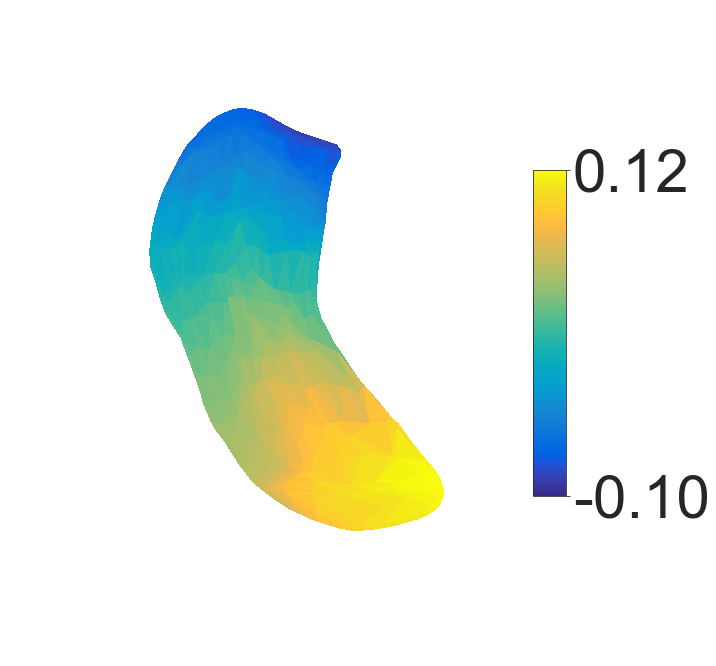

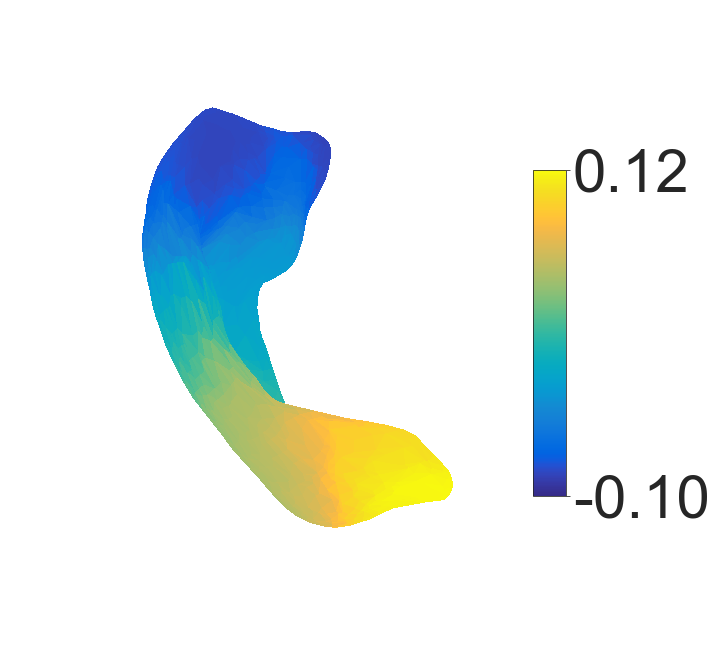

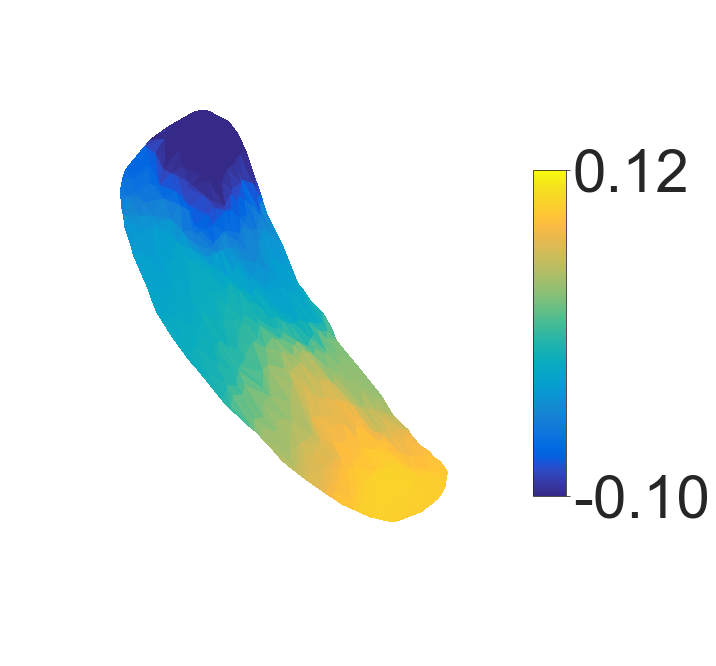

In [3]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G1_sic_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.10, 0.12)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_sic_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.10, 0.12)


fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_sic_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.10, 0.12)



## G2 (sic)

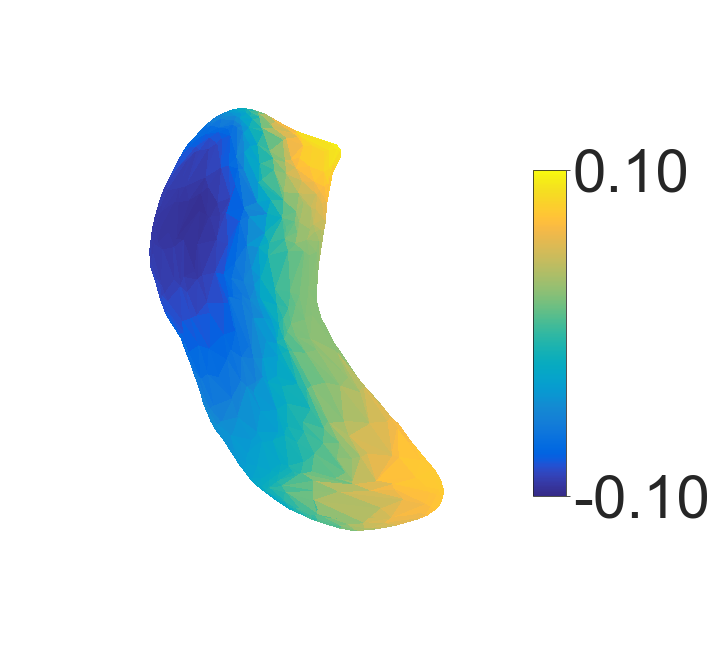

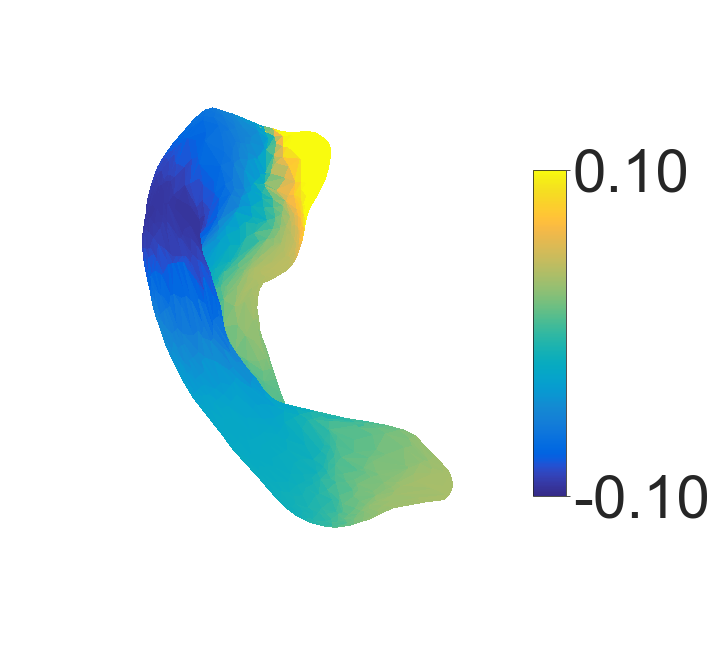

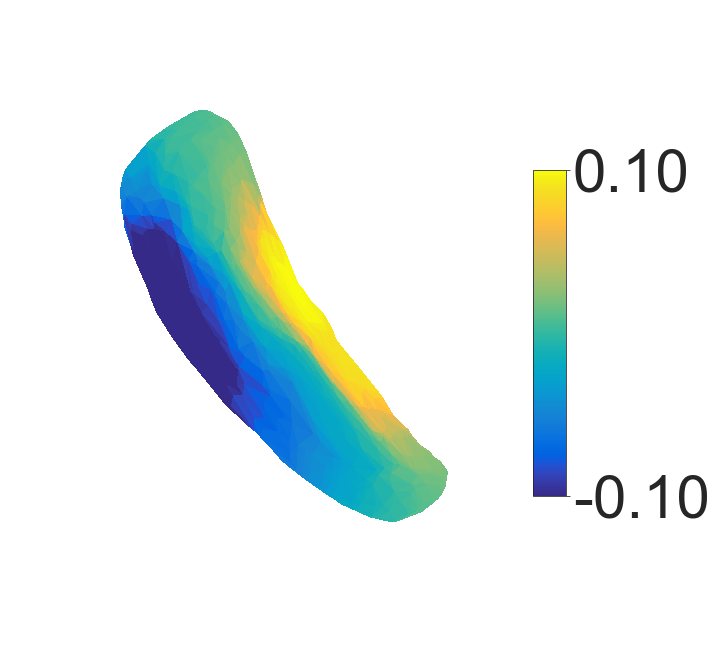

In [4]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G2_sic_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.10, 0.10)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_sic_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.10, 0.10)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_sic_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.10, 0.10)


### similarity between G1 (sic) and G1 (fc)

In [5]:
ddir = '../data/tout_group/'

# read-in primary and secongardy gradients (G1 & G2) for individual subfields
h1  = h5py.File(os.path.join(ddir, 'Hmean709connGradients_left.h5'), 'r');

G1_fc_LSUB = np.array(h1['gradients_'][0:1024,0])
G1_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,0])
G1_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,0])

G2_fc_LSUB = np.array(h1['gradients_'][0:1024,1])
G2_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,1])
G2_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,1])


In [6]:
print(pearsonr(G1_fc_LSUB, G1_sic_LSUB ))
print(pearsonr(G1_fc_LCA, G1_sic_LCA ))
print(pearsonr(G1_fc_LDG, G1_sic_LDG ))


(0.8902296752115295, 0.0)
(0.8771745985494763, 0.0)
(0.8945439903887564, 0.0)


In [7]:
print(pearsonr(G2_fc_LSUB, G2_sic_LSUB ))
print(pearsonr(G2_fc_LCA, G2_sic_LCA ))
print(pearsonr(G2_fc_LDG, G2_sic_LDG ))


(0.6524139616035582, 3.3388537957322113e-125)
(0.23901149691135498, 5.375809960081499e-28)
(0.15665429126088137, 4.705447210800642e-07)


### variogram matching to correct p-values for spatial-autocorrelations

In [8]:
from scipy.io import loadmat

ddir = '../data/tout_group/'

# get surface coordinates & triangles
LSUBfile = os.path.join(ddir, 'surf_lsub.mat')
LSUBsurf = loadmat(LSUBfile)['ave_lsub'][0,0]
xLSUB = LSUBsurf['coord'][0,:]           # (1024,)
yLSUB = LSUBsurf['coord'][1,:]           # (1024,)
zLSUB = -LSUBsurf['coord'][2,:]          # (1024,)

LCAfile = os.path.join(ddir, 'surf_lca.mat')
LCAsurf = loadmat(LCAfile)['ave_lca'][0,0];
xLCA = LCAsurf['coord'][0,:]           # (2048,)
yLCA = LCAsurf['coord'][1,:]           # (2048,)
zLCA = -LCAsurf['coord'][2,:]          # (2048,)

LDGfile = os.path.join(ddir, 'surf_ldg.mat')
LDGsurf = loadmat(LDGfile)['ave_ldg'][0,0];
xLDG = LDGsurf['coord'][0,:]           # (1024,)
yLDG = LDGsurf['coord'][1,:]           # (1024,)
zLDG = -LDGsurf['coord'][2,:]          # (1024,)

coord_LSUB = np.concatenate((xLSUB.reshape(1024,1), 
                             yLSUB.reshape(1024,1), 
                             zLSUB.reshape(1024,1)), axis=1)

coord_LCA  = np.concatenate((xLCA.reshape(2048,1), 
                             yLCA.reshape(2048,1), 
                             zLCA.reshape(2048,1)), axis=1)

coord_LDG  = np.concatenate((xLDG.reshape(1024,1), 
                             yLDG.reshape(1024,1), 
                             zLDG.reshape(1024,1)), axis=1)

In [9]:
points_LSUB = np.array(coord_LSUB, dtype='float64')
faces_LSUB  = np.array(LSUBsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LSUB = geodesic.PyGeodesicAlgorithmExact(points_LSUB, faces_LSUB)
distance_LSUB = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LSUB.geodesicDistances(sourceIndex, targetIndex)
    distance_LSUB[i, :] = distIndex

In [10]:
points_LCA = np.array(coord_LCA, dtype='float64')
faces_LCA  = np.array(LCAsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LCA = geodesic.PyGeodesicAlgorithmExact(points_LCA, faces_LCA)
distance_LCA = np.zeros((2048,2048))

for i in range(0, 2048):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LCA.geodesicDistances(sourceIndex, targetIndex)
    distance_LCA[i, :] = distIndex


In [11]:
points_LDG = np.array(coord_LDG, dtype='float64')
faces_LDG  = np.array(LDGsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LDG = geodesic.PyGeodesicAlgorithmExact(points_LDG, faces_LDG)
distance_LDG = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance and the path
    distIndex, best_source = geoalg_LDG.geodesicDistances(sourceIndex, targetIndex)
    distance_LDG[i, :] = distIndex

In [12]:
from scipy.sparse.csgraph import dijkstra

distance_LSUB = dijkstra(distance_LSUB, directed=False)
distance_LSUB_idx_sorted = np.argsort(distance_LSUB, axis=1)

distance_LCA = dijkstra(distance_LCA, directed=False)
distance_LCA_idx_sorted = np.argsort(distance_LCA, axis=1)

distance_LDG = dijkstra(distance_LDG, directed=False)
distance_LDG_idx_sorted = np.argsort(distance_LDG, axis=1)

In [13]:
from brainspace.null_models import SampledSurrogateMaps

n_surrogate_datasets = 1000

# Note: number samples must be greater than number neighbors
num_samples = 100
num_neighbors = 50

ssm_LSUB = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LSUB.fit(distance_LSUB, distance_LSUB_idx_sorted)

ssm_LCA = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LCA.fit(distance_LCA, distance_LCA_idx_sorted)

ssm_LDG = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LDG.fit(distance_LDG, distance_LDG_idx_sorted)


G1_sic_LSUB_surrogates = ssm_LSUB.randomize(G1_sic_LSUB, n_rep=n_surrogate_datasets)
G1_sic_LCA_surrogates = ssm_LCA.randomize(G1_sic_LCA, n_rep=n_surrogate_datasets)
G1_sic_LDG_surrogates = ssm_LDG.randomize(G1_sic_LDG, n_rep=n_surrogate_datasets)

G2_sic_LSUB_surrogates = ssm_LSUB.randomize(G2_sic_LSUB, n_rep=n_surrogate_datasets)
G2_sic_LCA_surrogates = ssm_LCA.randomize(G2_sic_LCA, n_rep=n_surrogate_datasets)
G2_sic_LDG_surrogates = ssm_LDG.randomize(G2_sic_LDG, n_rep=n_surrogate_datasets)


G1_lsub:
 ABC 0.89023 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.87717 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_ldg:
 ABC 0.89454 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00



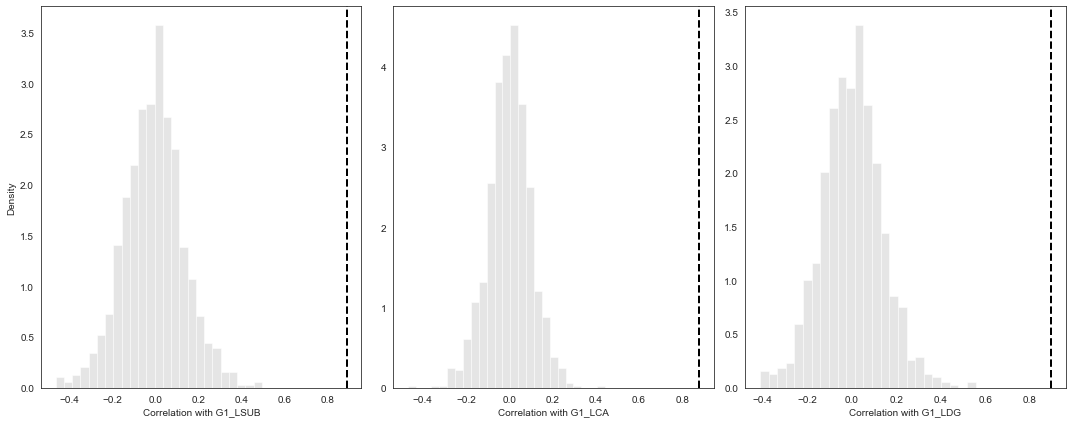

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_sic_LSUB,
         'G1_LCA' : G1_sic_LCA,
         'G1_LDG' : G1_sic_LDG}

rand = {'G1_LSUB': G1_sic_LSUB_surrogates,
           'G1_LCA' : G1_sic_LCA_surrogates,
           'G1_LDG' : G1_sic_LDG_surrogates}


for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G1_fc_LSUB
                
    if k == 1:
        XG = G1_fc_LCA
        
    if k == 2:
        XG = G1_fc_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

G2_lsub:
 ABC 0.65241 
 Obs      : 3.33885e-125
 Variogram: 0.00000e+00

G2_lca:
 ABC 0.23901 
 Obs      : 5.37581e-28
 Variogram: 1.60000e-02

G2_ldg:
 ABC 0.15665 
 Obs      : 4.70545e-07
 Variogram: 2.12000e-01



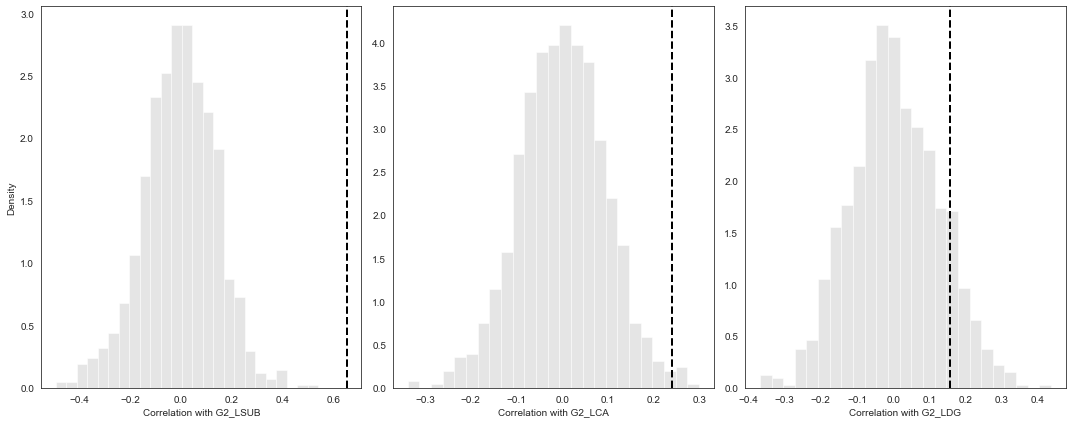

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G2_LSUB': G2_sic_LSUB,
         'G2_LCA' : G2_sic_LCA,
         'G2_LDG' : G2_sic_LDG}

rand = {'G2_LSUB': G2_sic_LSUB_surrogates,
           'G2_LCA' : G2_sic_LCA_surrogates,
           'G2_LDG' : G2_sic_LDG_surrogates}


for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G2_fc_LSUB
                
    if k == 1:
        XG = G2_fc_LCA
        
    if k == 2:
        XG = G2_fc_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

# projections of G1 (sic) onto the isocortical sic

In [16]:
# load surfaces
surf_lh, surf_rh = load_conte69()

# load labeling file
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

mask = labeling != 0 # this takes the mask of the left hem only..

mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


### get the structural intensity covariance of LSUB and isocortex

In [17]:
outdir = '../data/tout_group/'

hLSUB = h5py.File(os.path.join(outdir, 'scov_cortex_LSUB709_corr.h5'), 'r')
scov_corr_LSUB_cortex = np.array(hLSUB['data'])  ### (1384, 1384)
scov_corr_LSUB = scov_corr_LSUB_cortex[360:,0:360]   

In [18]:
# get correlations along the isocortex
r1_LSUB = np.zeros((360,))
for k in range(0, 360):
    r1_LSUB[k] = np.corrcoef(scov_corr_LSUB.T[k,:], G1_sic_LSUB)[-1:,:-1][0,0]
    
r1_LSUB.shape, r1_LSUB.min(), r1_LSUB.max(), scov_corr_LSUB.shape

((360,), -0.6547107663227049, 0.800152175401592, (1024, 360))

In [19]:
# label correlation values to the freesurfer space
r1_LSUB_labeled = map_to_labels(r1_LSUB, labeling, mask=mymask) 
r1_LSUB_labeled[np.where(mymask == False)] = np.nan

print(r1_LSUB_labeled.shape, np.nanmin(r1_LSUB_labeled), np.nanmax(r1_LSUB_labeled))

(64984,) -0.6547107663227049 0.800152175401592


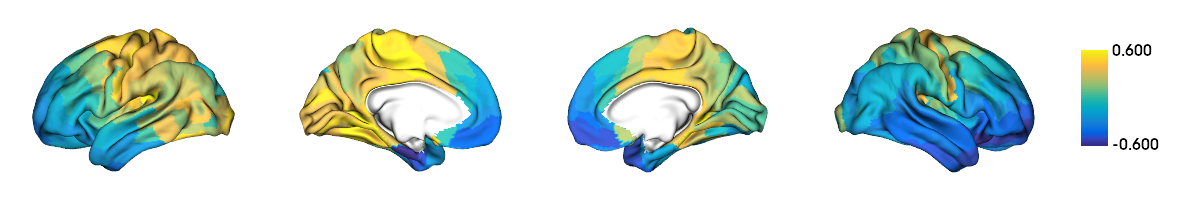

In [20]:
# plot G1 (sic) projections on isocortex
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.6, 0.6),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 )

### get the structural intensity covariance of LCA and isocortex

In [21]:
hLCA = h5py.File(os.path.join(outdir, 'scov_cortex_LCA709_corr.h5'), 'r')
scov_corr_LCA_cortex = np.array(hLCA['data'])  ### (1384, 1384)
scov_corr_LCA = scov_corr_LCA_cortex[360:,0:360]   

r1_LCA = np.zeros((360,))
for k in range(0, 360):
    r1_LCA[k] = np.corrcoef(scov_corr_LCA.T[k,:], G1_sic_LCA)[-1:,:-1][0,0]

r1_LCA_labeled = map_to_labels(r1_LCA, labeling, mask=mymask) 
r1_LCA_labeled[np.where(mymask == False)] = np.nan

print(r1_LCA_labeled.shape, np.nanmin(r1_LCA_labeled), np.nanmax(r1_LCA_labeled))

(64984,) -0.3657034838659357 0.8765701854220431


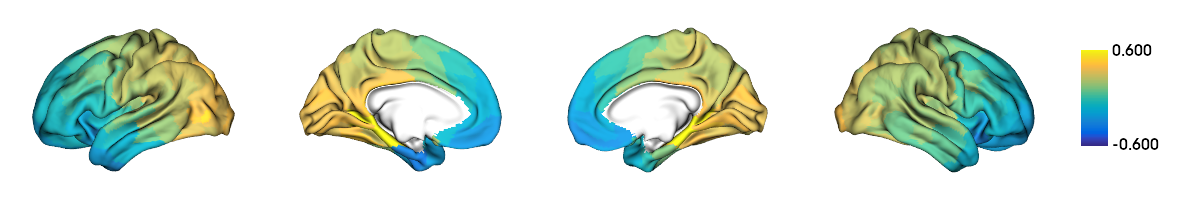

In [22]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.6, 0.6),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True)

### get the structural intensity covariance of LDG and isocortex

In [23]:
hLDG = h5py.File(os.path.join(outdir, 'scov_cortex_LDG709_corr.h5'), 'r')
scov_corr_LDG_cortex = np.array(hLDG['data'])  ### (1384, 1384)
scov_corr_LDG = scov_corr_LDG_cortex[360:,0:360]   

r1_LDG = np.zeros((360,))
for k in range(0, 360):
    r1_LDG[k] = np.corrcoef(scov_corr_LDG.T[k,:], G1_sic_LDG)[-1:,:-1][0,0]

r1_LDG_labeled = map_to_labels(r1_LDG, labeling, mask=mymask) 
r1_LDG_labeled[np.where(mymask == False)] = np.nan

print(r1_LDG_labeled.shape, np.nanmin(r1_LDG_labeled), np.nanmax(r1_LDG_labeled))

(64984,) -0.6945281986531968 0.3018910923207649


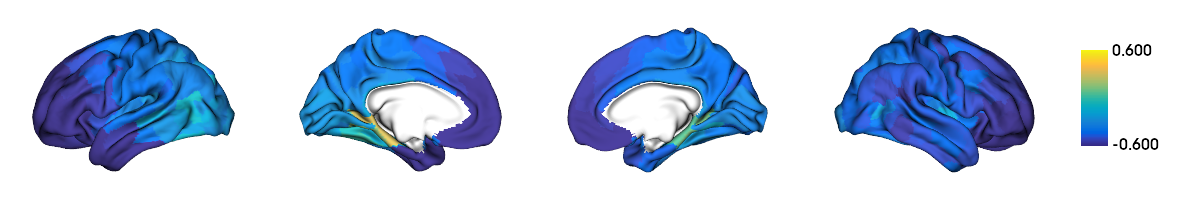

In [24]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.6, 0.6),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True)

## read-in gradients of the genetic correlations (of the structural intensity covariance)

In [25]:
gLSUB = h5py.File(os.path.join(outdir, 'scov_cortex_hipp_gencor_gradients_LSUB.h5'), 'r')
dataLSUB = np.array(gLSUB['data'])

gLCA = h5py.File(os.path.join(outdir, 'scov_cortex_hipp_gencor_gradients_LCA.h5'), 'r')
dataLCA = np.array(gLCA['data'])

gLDG = h5py.File(os.path.join(outdir, 'scov_cortex_hipp_gencor_gradients_LDG.h5'), 'r')
dataLDG = np.array(gLDG['data'])

G1_gen_LSUB = dataLSUB[:,0]
G1_gen_LCA  = dataLCA[:,0]
G1_gen_LDG  = dataLDG[:,0] 

G2_gen_LSUB = dataLSUB[:,1]
G2_gen_LCA  = dataLCA[:,1]
G2_gen_LDG  = dataLDG[:,1] 

## G1 (gen)

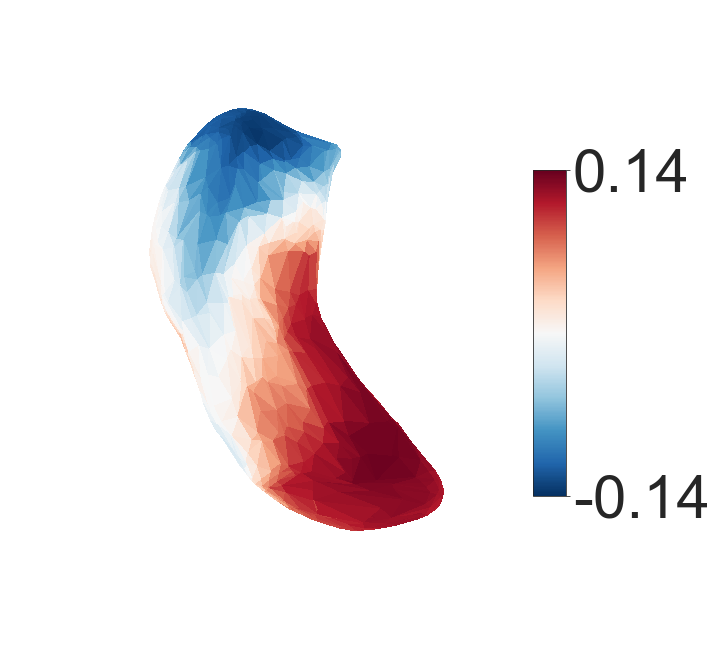

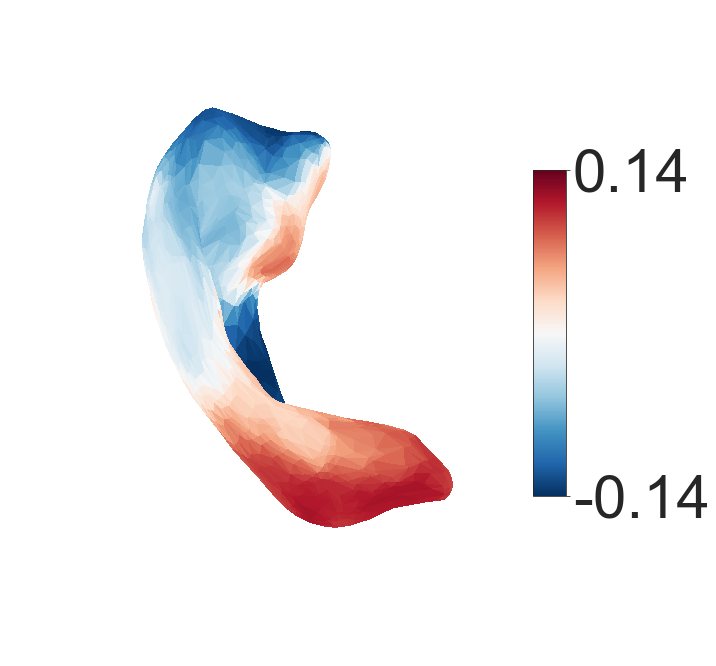

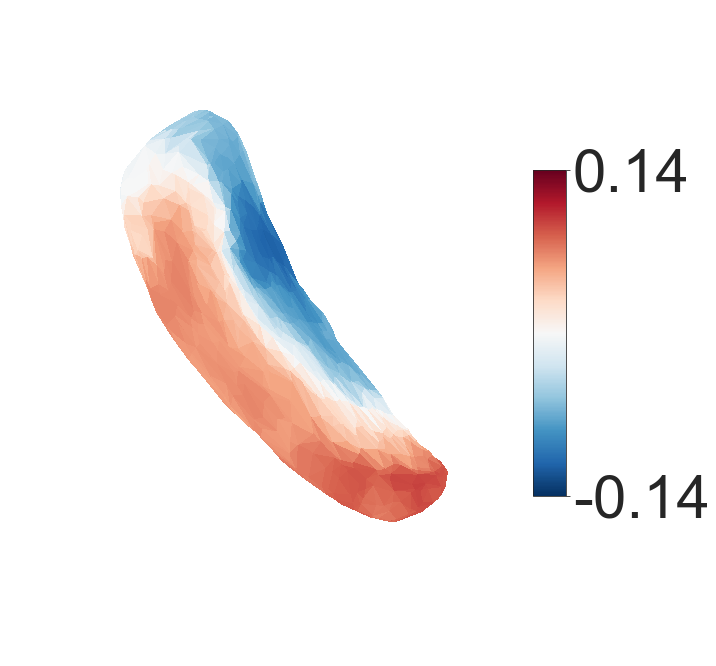

In [26]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB,
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G1_gen_LSUB, 
                                  'RdBu_r', -0.14, 0.14)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_gen_LCA,
                                   'RdBu_r', -0.14, 0.14)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_gen_LDG,
                                   'RdBu_r', -0.14, 0.14)

## G2 (gen)

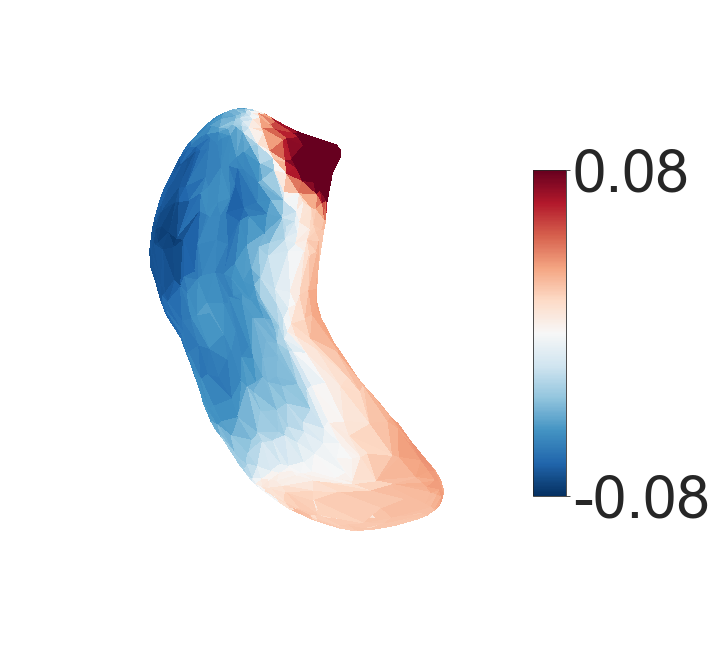

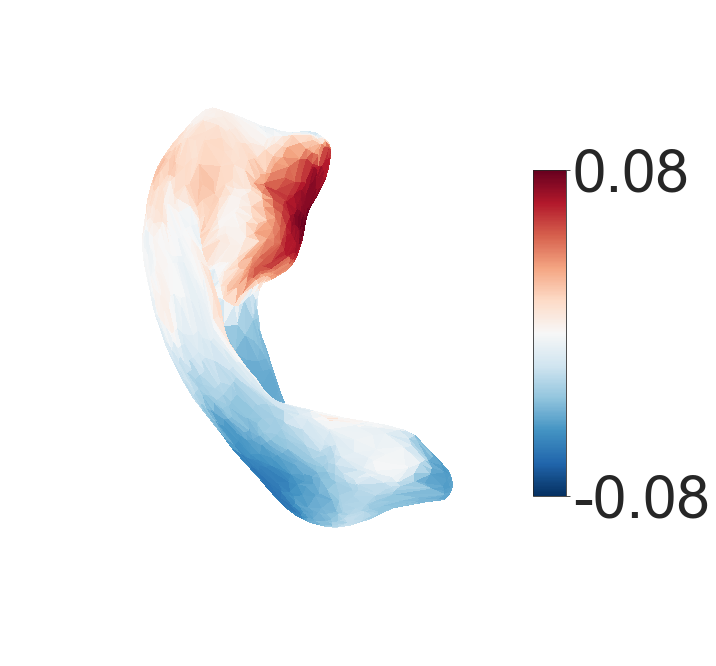

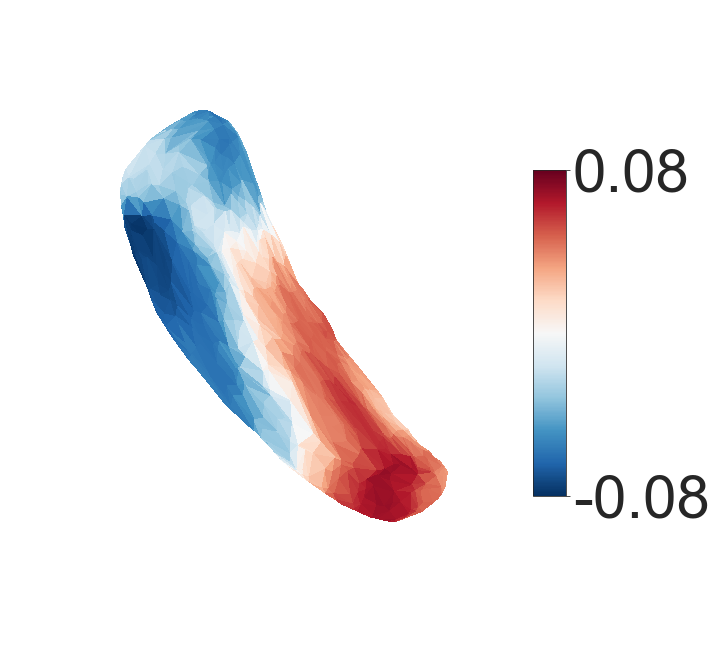

In [27]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB,
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G2_gen_LSUB, 
                                  'RdBu_r', -0.08, 0.08)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_gen_LCA,
                                   'RdBu_r',-0.08, 0.08)
fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_gen_LDG,
                                   'RdBu_r', -0.08, 0.08)

## similarities between G1 (gen) and G1 (FC)

In [28]:
print(pearsonr(G1_fc_LSUB, G1_gen_LSUB ))
print(pearsonr(G1_fc_LCA, G1_gen_LCA ))
print(pearsonr(G1_fc_LDG, G1_gen_LDG ))


(0.7428925126469877, 2.4195883738213256e-180)
(0.4406101851921653, 5.087953988249566e-98)
(0.26421049274419933, 8.137158710767582e-18)


In [29]:
G1_gen_LSUB_surrogates = ssm_LSUB.randomize(G1_gen_LSUB, n_rep=n_surrogate_datasets)
G1_gen_LCA_surrogates = ssm_LCA.randomize(G1_gen_LCA, n_rep=n_surrogate_datasets)
G1_gen_LDG_surrogates = ssm_LDG.randomize(G1_gen_LDG, n_rep=n_surrogate_datasets)


G1_lsub:
 ABC 0.74289 
 Obs      : 2.41959e-180
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.44061 
 Obs      : 5.08795e-98
 Variogram: 0.00000e+00

G1_ldg:
 ABC 0.26421 
 Obs      : 8.13716e-18
 Variogram: 5.50000e-02



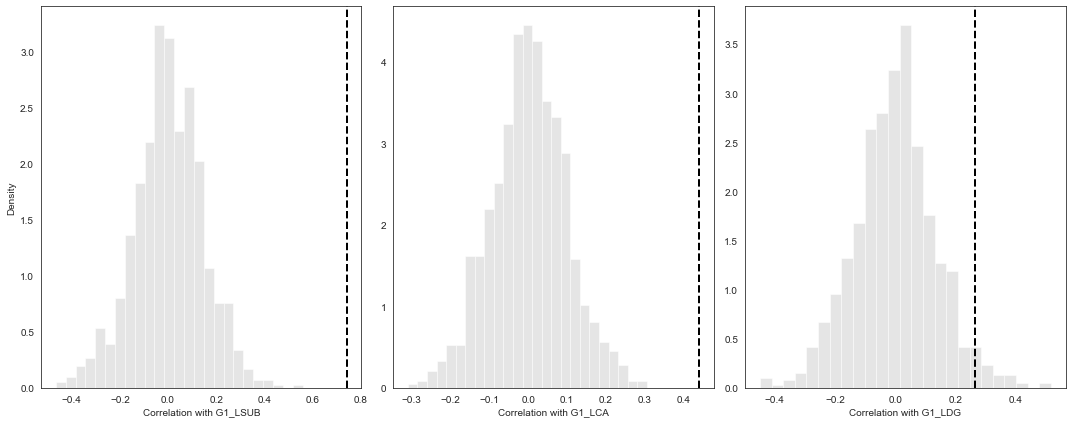

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_gen_LSUB,
         'G1_LCA' : G1_gen_LCA,
         'G1_LDG' : G1_gen_LDG}

rand = {'G1_LSUB': G1_gen_LSUB_surrogates,
           'G1_LCA' : G1_gen_LCA_surrogates,
           'G1_LDG' : G1_gen_LDG_surrogates}

for k, (fn, data) in enumerate(rand.items()):
    if k == 0:
        XG = G1_fc_LSUB   
    if k == 1:
        XG = G1_fc_LCA
    if k == 2:
        XG = G1_fc_LDG
    r_obs, pv_obs = pearsonr(feats[fn], XG)
    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

# projections of G1 (gen) onto the isocortical sic

In [31]:
outdir = '../data/tout_group/'

k = h5py.File(os.path.join(outdir, 'scov_cortex_hipp_gencor360_4096.h5'), 'r')
gen_corr = np.array(k['data'])  ### (360, 4096)
k.close()

genncorr_LSUB = gen_corr[:,0:1024]
genncorr_LCA  = gen_corr[:,1024:1024+2048]
genncorr_LDG  = gen_corr[:,1024+2048:1024+2048+1024]

In [32]:
c1_LSUB = np.zeros((360,))
c1_LCA  = np.zeros((360,))
c1_LDG = np.zeros((360,))

for k in range(0, 360):
    c1_LSUB[k] = np.corrcoef(genncorr_LSUB[k,:], G1_gen_LSUB)[-1:,:-1][0,0]
    c1_LCA[k]  = np.corrcoef(genncorr_LCA[k,:], G1_gen_LCA)[-1:,:-1][0,0]
    c1_LDG[k]  = np.corrcoef(genncorr_LDG[k,:], G1_gen_LDG)[-1:,:-1][0,0]

In [33]:
c1_LSUB_labeled = map_to_labels(c1_LSUB, labeling, mask=mymask) 
c1_LSUB_labeled[np.where(mymask == False)] = np.nan

print(c1_LSUB_labeled.shape, np.nanmin(c1_LSUB_labeled), np.nanmax(c1_LSUB_labeled))

c1_LCA_labeled = map_to_labels(c1_LCA, labeling, mask=mymask) 
c1_LCA_labeled[np.where(mymask == False)] = np.nan

print(c1_LCA_labeled.shape, np.nanmin(c1_LCA_labeled), np.nanmax(c1_LCA_labeled))

c1_LDG_labeled = map_to_labels(c1_LDG, labeling, mask=mymask) 
c1_LDG_labeled[np.where(mymask == False)] = np.nan

print(c1_LDG_labeled.shape, np.nanmin(c1_LDG_labeled), np.nanmax(c1_LDG_labeled))

(64984,) -0.9146450055587282 0.789597635740057
(64984,) -0.8710380471981659 0.6415929268117015
(64984,) -0.889624551118949 0.5338882079844756


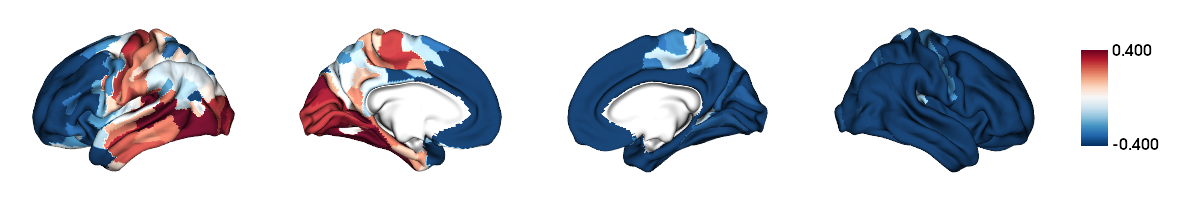

In [34]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True)

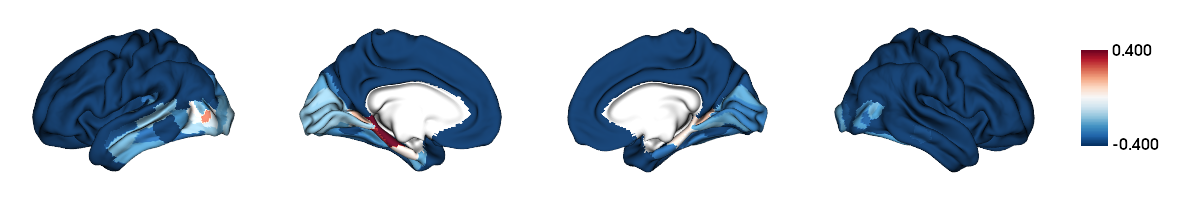

In [35]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True)

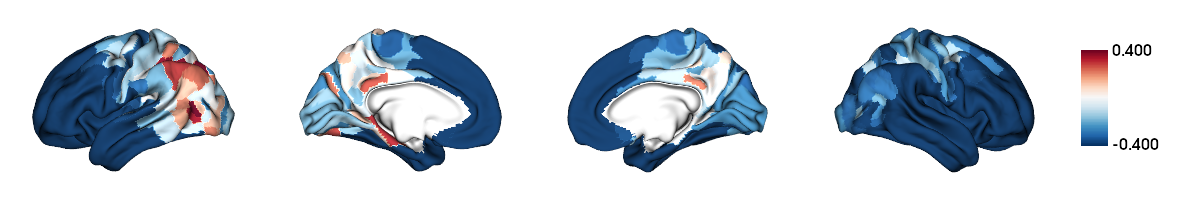

In [36]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True)